# **Exploration for pre-processing**

- The goal here is to explore the instances and the labels to answer the following question : **`How should I pre-process the data ?`**

In [1]:
import sys
from pathlib import Path
import logging 

LOGGER = logging.getLogger(__name__)
sys.path.append(str(Path("../src").resolve()))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
import polars as pl 

instances = pl.read_parquet((Path().cwd().parent / "data/02_intermediate/instances.parquet").as_posix()).to_pandas()
labels = pl.read_parquet((Path().cwd().parent / "data/02_intermediate/labels.parquet").as_posix()).to_pandas()

# **Labels exploration**

## **1 - Labels overview**

In [3]:
df = labels.fraud_reported.value_counts().to_frame(name = "nb_fraud")
df.loc[:, "%_fraud"] = labels.fraud_reported.value_counts(normalize = True)
df

,nb_fraud,%_fraud
fraud_reported,,
N,753,0.753
Y,247,0.247


- The labels contain 25% of reported frauds
- The ML problem will be an imbalanced binary classification (1 if fraud reported else 0)

# **Instances exploration**

In [4]:
import numpy as np 

numerical_data = instances.select_dtypes(include=[np.number])
categorical_data = instances.select_dtypes(include=['category', 'object'])

## **1 - Categorical data**

In [5]:
categorical_data.columns

Index(['policy_state', 'insured_education_level', 'insured_occupation',
       'insured_hobbies', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'property_damage', 'police_report_available',
       'auto_make'],
      dtype='object')

In [6]:
for col in categorical_data.columns : 
    LOGGER.info(f"'{col}' unique values : {categorical_data[col].value_counts(dropna=False).to_dict()}")

2025-07-13 10:11:56,772 : INFO : 'policy_state' unique values : {'OH': 352, 'IL': 338, 'IN': 310}
2025-07-13 10:11:56,775 : INFO : 'insured_education_level' unique values : {'JD': 161, 'High School': 160, 'Associate': 145, 'MD': 144, 'Masters': 143, 'PhD': 125, 'College': 122}
2025-07-13 10:11:56,777 : INFO : 'insured_occupation' unique values : {'machine-op-inspct': 93, 'prof-specialty': 85, 'tech-support': 78, 'sales': 76, 'exec-managerial': 76, 'craft-repair': 74, 'transport-moving': 72, 'priv-house-serv': 71, 'other-service': 71, 'armed-forces': 69, 'adm-clerical': 65, 'protective-serv': 63, 'handlers-cleaners': 54, 'farming-fishing': 53}
2025-07-13 10:11:56,780 : INFO : 'insured_hobbies' unique values : {'reading': 64, 'exercise': 57, 'paintball': 57, 'bungie-jumping': 56, 'movies': 55, 'camping': 55, 'golf': 55, 'kayaking': 54, 'yachting': 53, 'hiking': 52, 'video-games': 50, 'base-jumping': 49, 'skydiving': 49, 'board-games': 48, 'polo': 47, 'chess': 46, 'dancing': 43, 'sleeping

- Identified values for missing values : "?", "None" -> in this case "None" doesn't seem to be a missing information
- Grouping high cardinality features for more simplicity : 
    - `insured_occupation` : grouping by CSP to reduce cardinality and ranking by 'prestige' to give a logical ordinal encoding
        {
            "0 : agriculture": [
                "farming-fishing"
            ],
            "4 : craftmen_traders_entrepreneurs": [
                "craft-repair",
                "transport-moving"
            ],
            "6 : higher_professions": [
                "prof-specialty",
                "exec-managerial"
            ],
            "5 : intermediate": [
                "tech-support",
                "adm-clerical",
                "sales",
                "protective-serv"
            ],
            "1 : employees": [
                "priv-house-serv",
                "other-service",
                "handlers-cleaners"
            ],
            "2 : workers": [
                "machine-op-inspct"
            ],
            "3 : military": [
                "armed-forces"
            ]
        }
    - `insured_hobbies` : grouping by category to reduce cardinality
        {
            "intellectual_hobbies": [
                "reading",
                "chess",
                "board-games"
            ],
            "fitness_and_sports": [
                "exercise",
                "cross-fit",
                "basketball",
                "dancing"
            ],
            "extreme_sports": [
                "paintball",
                "bungie-jumping",
                "base-jumping",
                "skydiving"
            ],
            "outdoor": [
                "camping",
                "hiking",
                "kayaking",
            ],
            "entertainment": [
                "movies",
                "video-games",
                "sleeping"
            ]
            "premium_hobbies": [
                "yachting",
                "golf",
                "polo"
            ]
        }
    - `auto_make` : grouping by category to reduce cardinality 
        {
            "2 : premium": [
                "Mercedes",
                "BMW",
                "Audi",
                "Accura"
            ],
            "1 : semi_premium": [
                "Jeep",
                "Volkswagen",
                "Saab"
            ],
            "0 : mainstream_and_reliable": [
                "Toyota",
                "Honda",
                "Suburu",
                "Nissan",
                "Ford",
                "Chevrolet",
                "Dodge"
            ]
        }

- Risks of this approach :
    - we can lose information if the grouping is not done properly -> decrease in model performance but faster convergence during training
    - each category may have a completely different behavior than other similar categories

In [8]:
import pandas as pd 

high_cardinality = pd.merge(
    left = instances[["policy_number", "insured_occupation", "insured_hobbies", "auto_make"]],
    right = labels,
    on = "policy_number", 
    how = "inner"
)
high_cardinality.sample(n=3)

,policy_number,insured_occupation,insured_hobbies,auto_make,fraud_reported
247,187775,other-service,chess,Chevrolet,Y
60,598554,machine-op-inspct,base-jumping,Nissan,Y
549,788502,armed-forces,dancing,BMW,N


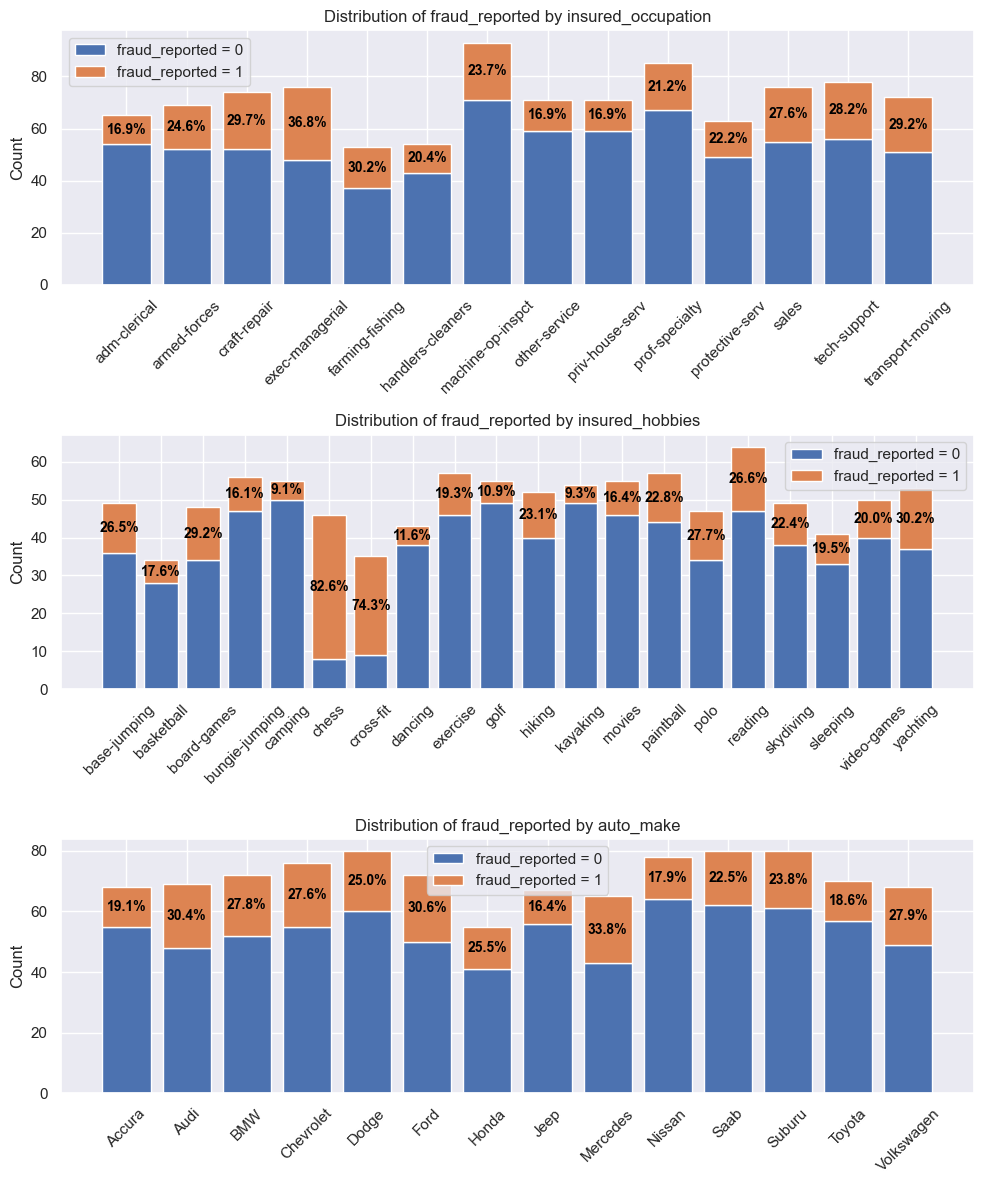

In [17]:
import seaborn as sns 
import matplotlib.pyplot as plt 

features = ['insured_occupation', 'insured_hobbies', 'auto_make']

sns.set_theme()
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

for i, feature in enumerate(features):
    ax = axes[i]

    # Get counts of each category for target=1 and total
    total_counts = high_cardinality[feature].value_counts().sort_index()
    positive_counts = high_cardinality[high_cardinality['fraud_reported'] == "Y"][feature].value_counts().sort_index()
    
    # Align index to ensure all categories are present
    positive_counts = positive_counts.reindex(total_counts.index, fill_value=0)
    negative_counts = total_counts - positive_counts

    # Calculate % of target = 1
    percent_target_1 = (positive_counts / total_counts) * 100
    percent_target_0 = 100 - percent_target_1
    
    # Stacked barplot
    ax.bar(total_counts.index, negative_counts, label='fraud_reported = 0')
    ax.bar(total_counts.index, positive_counts, bottom=negative_counts, label='fraud_reported = 1')
    # Add % labels on the top segment (target = 1)
    for idx, cat in enumerate(total_counts.index):
        total = total_counts[cat]
        pct = percent_target_1[cat]
        y = negative_counts[cat] + (positive_counts[cat] / 2)
        ax.text(idx, y, f'{pct:.1f}%', ha='center', va='center', color='black', fontsize=10, fontweight='bold')

    ax.set_title(f'Distribution of fraud_reported by {feature}')
    ax.set_ylabel('Count')
    ax.legend()
    ax.set_xticks(range(len(total_counts.index)))
    ax.set_xticklabels(total_counts.index, rotation=45)

plt.tight_layout()
plt.show()

- for all 3 columns the fraud distribution seems pretty even among the categories
- for insured_hobbies the fraud rate seems particularily 

## **2 - Numerical data**

In [7]:
import pandas as pd 

missing_values_rate = pd.Series()
for col in numerical_data.columns:
    missing_values_rate.loc[col] = numerical_data[numerical_data[col].isna()].shape[0] / numerical_data.shape[0]
missing_values_rate

months_as_customer                         0.0
age                                        0.0
policy_number                              0.0
policy_deductable                          0.0
policy_annual_premium                      0.0
umbrella_limit                             0.0
insured_zip                                0.0
capital-gains                              0.0
capital-loss                               0.0
incident_hour_of_the_day                   0.0
number_of_vehicles_involved                0.0
bodily_injuries                            0.0
witnesses                                  0.0
total_claim_amount                         0.0
injury_claim                               0.0
property_claim                             0.0
vehicle_claim                              0.0
auto_year                                  0.0
per_person_limit                           0.0
per_accident_limit                         0.0
nb_years_between_incident_and_bind_date    0.0
dtype: float6

- no missing values among the numerical data so we won't need imputation
- these are information that are systematically asked for when subscribing to an insurance policy so they are less likeky to contain missing values
- BUT : during inference we might encounter missing values (ex : a problem in the Data Pipeline that generated the latest version of the table, a human error,...)
- also the missing value rate depends on the **timing of the prediction** : 
    - For exampel if we predict at the moment of the claim declaration we might not have any informations about the total claim amount for example because we would need a bill that quantifies the amount the insurer will have to pay
    - this document could take a while to get our hands on
    - on the other hand if we predict at the moment we receive all the needed documents we might have a 0% missing data
- we also have a very limited amount of data so it is not representative of the reality of insurers data that are usually flooded with missing data

In [8]:
numerical_data.describe(percentiles=[i/10 for i in range(10)])

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,...,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,per_person_limit,per_accident_limit,nb_years_between_incident_and_bind_date
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,...,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000,272.650000,580.200000,1.121045e+09
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,...,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861,161.603196,287.420547,6.354760e+08
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,...,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000,100.000000,300.000000,-4.731006e+06
0%,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,...,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000,100.000000,300.000000,-4.731006e+06
10%,58.900000,28.000000,185105.400000,500.000000,953.900000,0.000000e+00,437418.500000,0.000000,-65510.000000,2.000000,...,0.000000,0.000000,5756.00000,639.000000,650.000000,4157.000000,1997.000000,100.000000,300.000000,2.148350e+08
20%,98.800000,31.000000,283384.600000,500.000000,1050.656000,0.000000e+00,444216.600000,0.000000,-55420.000000,4.000000,...,0.000000,0.000000,33344.00000,2138.000000,3158.000000,24392.000000,1999.000000,100.000000,300.000000,4.695051e+08
30%,130.000000,33.000000,376178.800000,500.000000,1124.663000,0.000000e+00,452411.300000,0.000000,-48530.000000,7.000000,...,0.000000,1.000000,46842.00000,5040.000000,5080.000000,33600.000000,2001.000000,100.000000,300.000000,6.882195e+08
40%,161.600000,36.000000,458195.000000,1000.000000,1197.974000,0.000000e+00,459972.400000,0.000000,-39700.000000,9.000000,...,1.000000,1.000000,53280.00000,5910.000000,5980.000000,38232.000000,2003.000000,250.000000,500.000000,9.061296e+08
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,...,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000,250.000000,500.000000,1.107529e+09


In [ ]:
obvious_colinearity = numerical_data[["total_claim_amount",	"injury_claim",	"property_claim","vehicle_claim"]].copy()
obvious_colinearity.loc[:, "claim_sum"] = obvious_colinearity[["injury_claim","property_claim","vehicle_claim"]].sum(axis=1)
(obvious_colinearity.total_claim_amount == obvious_colinearity.claim_sum).value_counts(dropna=False)

True    1000
Name: count, dtype: int64

- total_claim_amount = sum(["injury_claim","property_claim","vehicle_claim"])
- we will first test by keeping the 3 detailed claim amounts because it can give an interesting information of the nature of the claim
- indeed the fraud may be more object and goods oriented than health oriented, or the other way around
- then we will test the model by keeping only the total amount

2025-07-11 13:11:02,531 : INFO : generated new fontManager


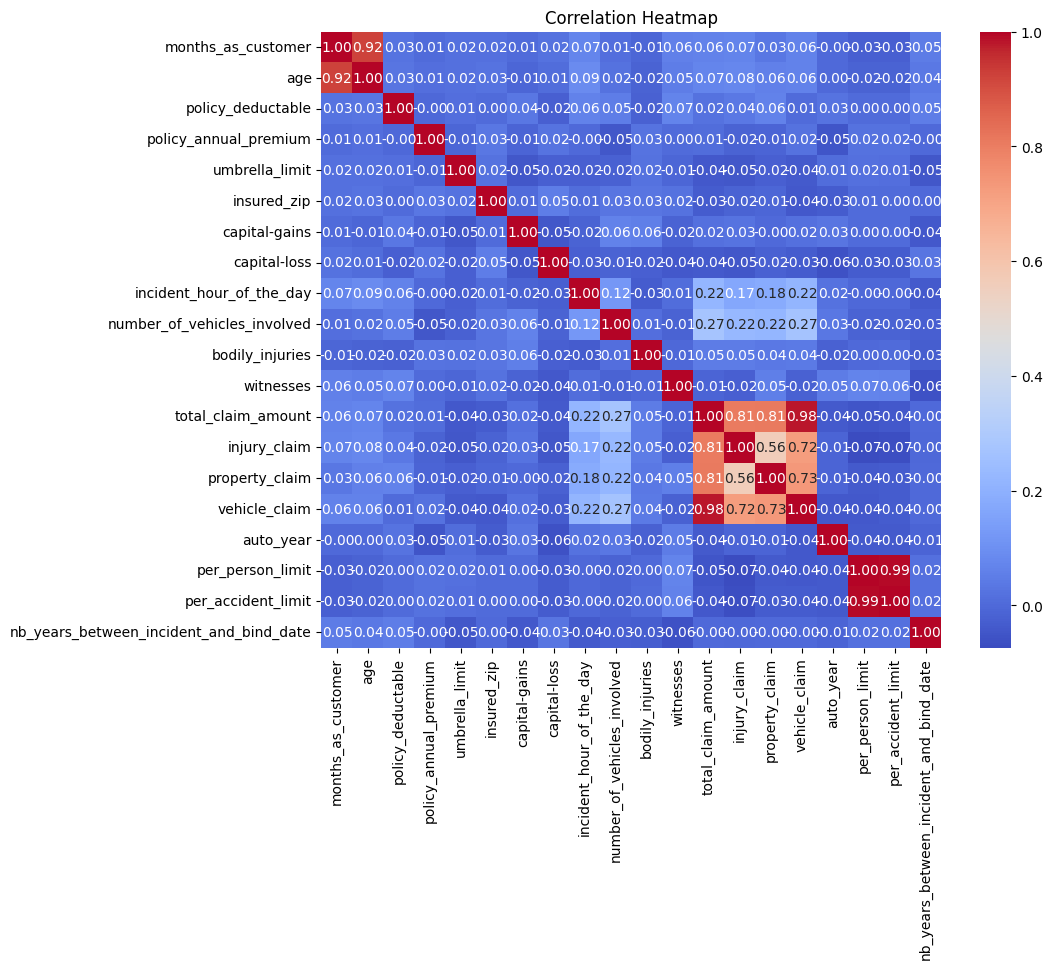

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = numerical_data.set_index("policy_number").corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

- other than the colinearity on the amounts, we observe strong correlation for the following sets of features : 
    - age & months_as_customer : 
        - it might not be wise the remove either one of them because the customer seriority often give valuable informations 
        - recent customer are usually more likely to fraud
    - per_person_limit and per_accident_limit 